In [1]:
%matplotlib inline
import os
from timeit import default_timer as timer
from glob import glob
import pandas as pd
import pyarrow.parquet as pq
from datetime import datetime
import numpy as np
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
country_code = "US"
print('Country:', country_code)

Country: US


In [3]:
if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/twitter/data'
else:
    path_to_data='../../data'

In [4]:
print('Load')
start = timer()
users=pq.ParquetDataset(glob(os.path.join(path_to_data,'classification',country_code,'users','*.parquet'))).read().to_pandas()
print("Done in", round(timer()-start), "sec")

Load
Done in 13 sec


In [5]:
labels=['loss', 'unemployed', 'search', 'hire', 'offer']
features=['statuses_count', 'account_age', 'followers_count', 'friends_count']
feature2label={
'statuses_count':'Number of tweets',
'account_age':'Age of account',
'followers_count':'Number of followers',
'friends_count':'Number of friends',
}

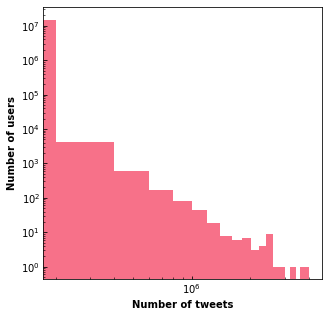

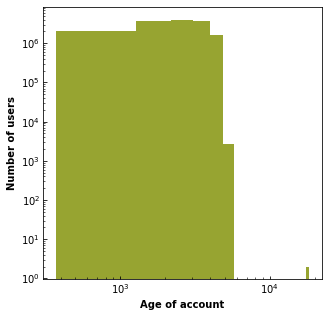

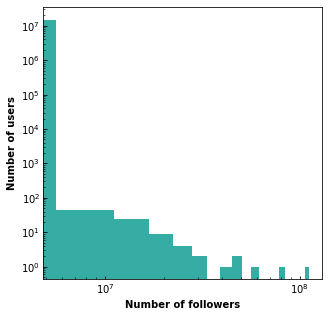

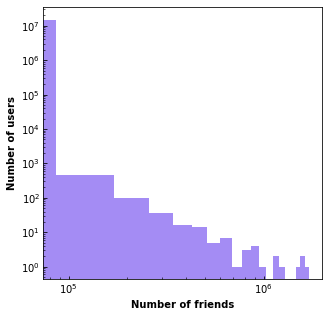

In [6]:
for i,feature in enumerate(features):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.hist(users[feature],bins=20,color=sns.color_palette("husl", len(features))[i])
    ax.tick_params(which='both',direction='in',pad=3)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(feature2label[feature],fontweight='bold')
    ax.set_ylabel('Number of users',fontweight='bold')

In [7]:
users[features].describe().astype(int)

,statuses_count,account_age,followers_count,friends_count
count,15194328,15194328,15194328,15194328
mean,2116,2540,630,327
std,10775,1041,56188,2020
min,0,370,0,0
25%,36,1616,12,34
50%,176,2635,44,109
75%,953,3341,165,295
max,4010357,18427,111813789,1718636


In [8]:
users[features].corr('spearman')

,statuses_count,account_age,followers_count,friends_count
statuses_count,1.000000,0.178414,0.714252,0.573821
account_age,0.178414,1.000000,0.190516,0.077371
followers_count,0.714252,0.190516,1.000000,0.736178
friends_count,0.573821,0.077371,0.736178,1.000000


In [9]:
users[labels].corr('spearman')

,loss,unemployed,search,hire,offer
loss,1.000000,0.014604,0.022881,0.012548,0.005308
unemployed,0.014604,1.000000,0.066171,0.007081,0.002332
search,0.022881,0.066171,1.000000,0.021068,0.005181
hire,0.012548,0.007081,0.021068,1.000000,0.003295
offer,0.005308,0.002332,0.005181,0.003295,1.000000


In [10]:
users[labels].mean()

loss          0.001190
unemployed    0.000725
search        0.008805
hire          0.000805
offer         0.022271
dtype: float64

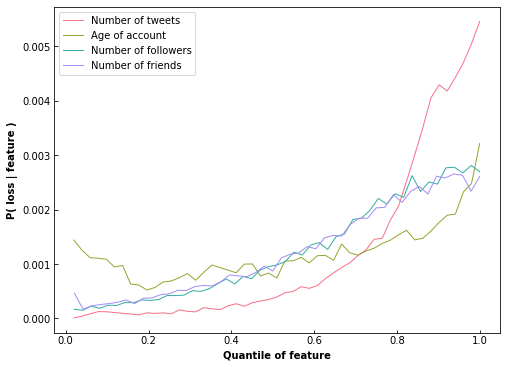

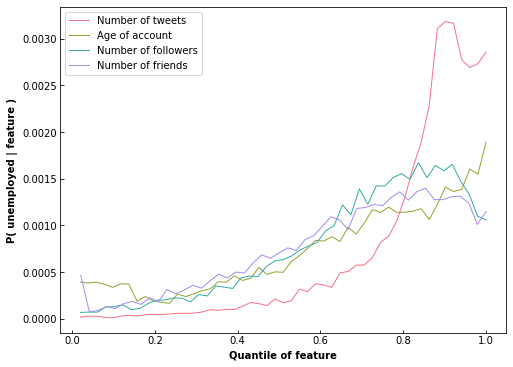

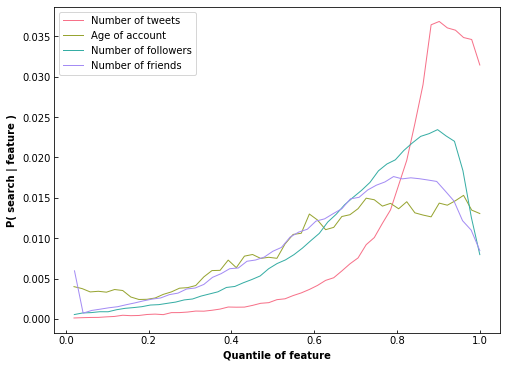

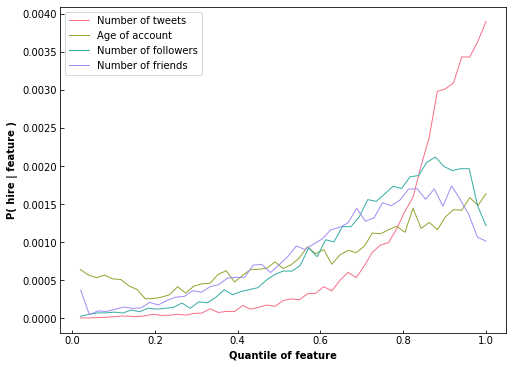

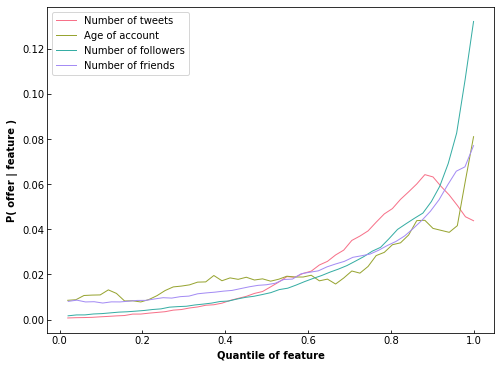

In [11]:
for label in labels:
    fig,ax = plt.subplots(figsize=(8,6))
    for i,feature in enumerate(features):
        df=users.groupby(pd.qcut(users[feature],51,duplicates='drop'))[label].mean()
        df.index=[x/df.shape[0] for x in range(1,df.shape[0]+1)]
        df.plot(ax=ax,
                label=feature2label[feature],
                color=sns.color_palette("husl", len(features))[i],
                linewidth=1,
                legend=True)
    ax.tick_params(which='both',direction='in',pad=3)
    ax.locator_params(axis='y',nbins=10)
    ax.set_ylabel('P( '+label+' | feature )',fontweight='bold')
    ax.set_xlabel('Quantile of feature',fontweight='bold')

In [12]:
print('Load...')
exog_cols=[[feature] for feature in features]+[features]
models={}
for label in labels:
    print()
    print(label)
    models[label]=[]
    for exog_col in exog_cols:
        print('\n'.join(exog_col))
        start = timer()
        models[label].append(sm.Logit(endog=users[label], exog=sm.add_constant(users[exog_col])).fit(show_r2 = False))
        end = timer()
        print('Computing time (in sec.):', round(end - start))
        break
    break

Load...

loss
statuses_count
Optimization terminated successfully.
         Current function value: 0.009182
         Iterations 11
Computing time (in sec.): 16


In [14]:
for label in labels:
    print(label)
    stargazer = Stargazer(models[label], show_r2 = False)
    stargazer.render_html()
    break

loss


AttributeError: 'LogitResults' object has no attribute 'rsquared'